In [1]:
from bins import Bins
from utils import calcAllChi2, calcOneChi2, HistMaker, diffHist
from ROOT import TFile, TH1, TCanvas, TStyle, gStyle, Form
import math

Welcome to JupyROOT 6.28/04


In [2]:
bins = Bins.readFrom("ranges.yml")
histMakerData = HistMaker("088_090_ag123ag_2500A_accepted_np.dat", "_data", bins)
#histsData = histMakerData.makeHists()
histsData = histMakerData.makeHists()
#histMakerMC = HistMaker("medium_isotropic_eff_ag1230ag_np_9deg.dat", "_MC", bins    )
#histMakerMC = HistMaker("mar19_diele_inmedium_heli0cm_np.dat", "_MC", bins    )
histMakerMC = HistMaker("mar19_diele_pi0_heli0cm_np.dat", "_MC", bins    )

allHistsMC = []

iter 0
Before processing events 06:18:18
After processing events 06:18:21
iter 1
Before processing events 06:18:27
After processing events 06:18:27


In [3]:
import torch

torch.device("mps")
torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [4]:
TH1.SetDefaultSumw2

N_PARAMS = 3

In [5]:
#lb = -1
#ub = 1

#bounds = torch.tensor([[lb]*N_PARAMS, [ub]*N_PARAMS], dtype=torch.float)
bounds = torch.tensor([[0, 0,         0],
                       [1, 2*math.pi, 2]], dtype=torch.float)

grid_r   = torch.linspace(bounds[0][0], bounds[1][0], 101)
grid_phi = torch.linspace(bounds[0][1], bounds[1][1], 101)
grid_z   = torch.linspace(bounds[0][2], bounds[1][2], 101)

grid_x1, grid_x2, grid_x3 = torch.meshgrid(grid_r, grid_phi, grid_z, indexing="ij")

xs = torch.vstack([grid_x1.flatten(), grid_x2.flatten(), grid_x3.flatten()]).transpose(-2,-1)

In [6]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

In [7]:
num_queries = 200
num_repeats = 1
num_samples = 1

In [8]:
def lambdas(xx):
   # return x[0], x[1], x[2]
    r, phi, z = xx[0], xx[1], xx[2]
    x = r*math.cos(phi)
    y = r*math.sin(phi)
    lambda_theta = 0.5 * (2*x + z)
    lambda_phi   = 0.25 * (-2 - 2*x + 3*z)
    lambda_theta_phi = y/math.sqrt(2.)
    return lambda_theta, lambda_phi, lambda_theta_phi

def all_lambdas(xx):
    def generator(xx):
        for x in xx:
            lambda_theta, lambda_phi, lambda_theta_phi = lambdas(x)
            yield torch.tensor([lambda_theta, lambda_phi, lambda_theta_phi])
           # yield torch.tensor([1./(chi2 / ndf)])
    return torch.stack([a for a in generator(xx)])
    
HIST_INDEX = 0

def objective(xx):
    def generator(xx):
        for x in xx:
            lambda_theta, lambda_phi, lambda_theta_phi = lambdas(x)

            histsMC = histMakerMC.makeHists(lambda_theta, lambda_phi, lambda_theta_phi)
            chi2, ndf = calcOneChi2(histsMC[0][HIST_INDEX], histsData[0][HIST_INDEX])
            allHistsMC.append(histsMC[0][HIST_INDEX])
            if not chi2 or not ndf:
                return torch.tensor([0])
            yield torch.tensor([1.0/(chi2 / ndf)])
           # yield torch.tensor([1./(chi2 / ndf)])
    return torch.stack([a for a in generator(xx)])

In [9]:
# -2 is the default value when no feasible has been found
default_value = 4000
feasible_incumbents = torch.ones((num_repeats, num_queries)) * default_value

for trial in range(num_repeats):
    print("trial", trial)

    torch.manual_seed(trial)
    train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
###                inequality_constraints=[(torch.tensor([0,2]),torch.tensor([-2.0,-1.0],dtype=torch.float),-2.0)],
    while -2.0*train_x[0][0] - 1.0*train_x[0][2] < -2:
        train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
    print(train_x)
    print(train_x.shape)
    train_utility = objective(train_x)

    for i in tqdm(range(num_queries)):
        feasible_incumbents[trial, i] = train_utility.max()
        utility_model, utility_likelihood = fit_gp_model(
            train_x, train_utility.squeeze(-1)
        )
        best_f = train_utility.max()
                
       # policy = botorch.acquisition.monte_carlo.qExpectedImprovement(
        policy = botorch.acquisition.analytic.LogExpectedImprovement(
       # policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
            model=utility_model,
            best_f=train_utility.max(),
        )

        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=RuntimeWarning)
            next_x, acq_val = botorch.optim.optimize_acqf(
                policy,
                bounds=bounds,
                q=1,
                num_restarts=40,
                raw_samples=100,
                inequality_constraints=[(torch.tensor([0,2]),torch.tensor([-2.0,-1.0],dtype=torch.float),-2.0)],
            )

        next_utility = objective(next_x)

        train_x = torch.cat([train_x, next_x])
        train_utility = torch.cat([train_utility, next_utility])

trial 0
tensor([[0.4963, 4.8269, 0.1770]])
torch.Size([1, 3])


  0%|          | 0/200 [00:00<?, ?it/s]

Before reweighting hists 06:18:45
After reweighting hists 06:18:45
Before reweighting hists 06:19:03
After reweighting hists 06:19:03
Before reweighting hists 06:19:22
After reweighting hists 06:19:22
Before reweighting hists 06:19:41
After reweighting hists 06:19:41
Before reweighting hists 06:20:00
After reweighting hists 06:20:01
Before reweighting hists 06:20:21
After reweighting hists 06:20:22
Before reweighting hists 06:20:42
After reweighting hists 06:20:42
Before reweighting hists 06:21:05
After reweighting hists 06:21:05
Before reweighting hists 06:21:28
After reweighting hists 06:21:28
Before reweighting hists 06:21:54
After reweighting hists 06:21:54
Before reweighting hists 06:22:19
After reweighting hists 06:22:20
Before reweighting hists 06:22:46
After reweighting hists 06:22:46
Before reweighting hists 06:23:12
After reweighting hists 06:23:12
Before reweighting hists 06:23:45
After reweighting hists 06:23:45
Before reweighting hists 06:24:18
After reweighting hists 06:2

In [10]:
torch.save(feasible_incumbents, f"./incumbents.pth")
fout = TFile("out_"+str(HIST_INDEX)+".root","RECREATE")
fout.cd()
for hist in allHistsMC:
    print ("Writing hist: ", hist.GetName())
    hist.Write()
for j, hists in enumerate(histsData):
    for k, hist in enumerate(hists):
            hist.Write()
            print ("Writing hist: ", j, k, hist)
fout.Close()

Writing hist:  hist_0to150_m06p00_MC_iter2
Writing hist:  hist_0to150_m06p00_MC_iter3
Writing hist:  hist_0to150_m06p00_MC_iter4
Writing hist:  hist_0to150_m06p00_MC_iter5
Writing hist:  hist_0to150_m06p00_MC_iter6
Writing hist:  hist_0to150_m06p00_MC_iter7
Writing hist:  hist_0to150_m06p00_MC_iter8
Writing hist:  hist_0to150_m06p00_MC_iter9
Writing hist:  hist_0to150_m06p00_MC_iter10
Writing hist:  hist_0to150_m06p00_MC_iter11
Writing hist:  hist_0to150_m06p00_MC_iter12
Writing hist:  hist_0to150_m06p00_MC_iter13
Writing hist:  hist_0to150_m06p00_MC_iter14
Writing hist:  hist_0to150_m06p00_MC_iter15
Writing hist:  hist_0to150_m06p00_MC_iter16
Writing hist:  hist_0to150_m06p00_MC_iter17
Writing hist:  hist_0to150_m06p00_MC_iter18
Writing hist:  hist_0to150_m06p00_MC_iter19
Writing hist:  hist_0to150_m06p00_MC_iter20
Writing hist:  hist_0to150_m06p00_MC_iter21
Writing hist:  hist_0to150_m06p00_MC_iter22
Writing hist:  hist_0to150_m06p00_MC_iter23
Writing hist:  hist_0to150_m06p00_MC_ite

In [11]:
#t = torch.tensor( [ [-1.0000, -0.4678,  0.5433]])
#print(t)
#print(t.shape)

In [12]:
with torch.no_grad():
    predictive_distribution = utility_likelihood(utility_model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()
    acquisition_score = policy(xs.unsqueeze(1))

In [13]:
from ipywidgets import interact, Layout, IntSlider
import numpy as np

axis_titles = [r"R of cone coordinates", r"$\Phi$ of cone coordinates", r"Z of cone coordinates"]

def oneplot(ax, tensor, index, cmap, title, transpose=None):
        
        global xs
        tensor_3d = torch.reshape(tensor, (101,101,101))
        xs_3d = torch.reshape(xs, (101,101,101,3))
        if transpose:
               tensor_3d = tensor_3d.transpose(transpose[0],transpose[1])
               xs_3d     = xs_3d    .transpose(transpose[0],transpose[1])
        if transpose is None:
                extent=[
                        xs_3d[0][0][0][2],
                        xs_3d[0][0][-1][2],
                        xs_3d[0][0][0][1],
                        xs_3d[0][-1][0][1],
                ]
        elif transpose == (0,1):
                extent=[
                        xs_3d[0][0][0][2],
                        xs_3d[0][0][-1][2],
                        xs_3d[0][0][0][0],
                        xs_3d[0][-1][0][0],
                ]
        elif transpose == (0,2):
                extent=[
                        xs_3d[0][0][0][0],
                        xs_3d[0][0][-1][0],
                        xs_3d[0][0][0][1],
                        xs_3d[0][-1][0][1],
                ]
        if transpose is None:
                x_title=axis_titles[2]
                y_title=axis_titles[1]
        elif transpose == (0, 1):
                x_title=axis_titles[2]
                y_title=axis_titles[0]
        elif transpose == (0,2):
                x_title=axis_titles[0]
                y_title=axis_titles[1]
        
        pos = ax.imshow(tensor_3d[index], cmap=cmap, interpolation="nearest", origin="lower", 
                vmin=tensor.min(), vmax=tensor.max(), extent=extent)
        ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2]))
        ax.set_title(title)
        ax.set_xlabel(x_title)
        ax.set_ylabel(y_title)
        plt.colorbar(pos,fraction=0.046, pad=0.04)

def ff(x, transpose):
        cmap = "gist_rainbow"
        fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)
        oneplot(ax[0], predictive_mean, x, cmap, "value", transpose)
        oneplot(ax[1], predictive_upper-predictive_lower, x, cmap, "confidence int. width", transpose)
        oneplot(ax[2], acquisition_score, x, cmap, "acquisition score", transpose)

def f(x):
        ff(x, None)

interact(f, x=IntSlider(50, 0, 100, 1, layout=Layout(width='500px')))


interactive(children=(IntSlider(value=50, description='x', layout=Layout(width='500px')), Output()), _dom_clas…

<function __main__.f(x)>

In [14]:
def g(x):
        ff(x, (0,1))
           
interact(g, x=IntSlider(50, 0, 100, 1, layout=Layout(width='500px')))

interactive(children=(IntSlider(value=50, description='x', layout=Layout(width='500px')), Output()), _dom_clas…

<function __main__.g(x)>

In [15]:
def h(x):
        ff(x, (0,2))
           
interact(h, x=IntSlider(50, 0, 100, 1, layout=Layout(width='500px')))

interactive(children=(IntSlider(value=50, description='x', layout=Layout(width='500px')), Output()), _dom_clas…

<function __main__.h(x)>

In [16]:
lds = all_lambdas(train_x)
lambda_thetas     = lds.transpose(-2,-1)[0]
lambda_phis       = lds.transpose(-2,-1)[1]
lambda_theta_phis = lds.transpose(-2,-1)[2]
c = torch.stack((
    torch.arange(0,200, dtype=int),
    lambda_thetas[0:200],
    lambda_phis[0:200],
    lambda_theta_phis[0:200],
    train_utility.squeeze()[0:200],
    (feasible_incumbents==feasible_incumbents.max())[0],
    feasible_incumbents[0]
),0).transpose(-2,-1)
torch.set_printoptions(precision=4,threshold=10_000, linewidth=120)
c_sorted = c[c[:, 4].sort()[1]]
print(c_sorted)

tensor([[ 1.6100e+02,  8.6775e-01,  9.8526e-01, -7.9068e-02,  1.0570e+03,  0.0000e+00,  2.1782e+04],
        [ 1.9300e+02,  1.6962e-01,  9.1108e-01, -2.5941e-03,  1.1116e+03,  1.0000e+00,  2.2583e+04],
        [ 1.5600e+02,  9.3470e-01,  9.4080e-01, -2.5472e-03,  1.1392e+03,  0.0000e+00,  2.1782e+04],
        [ 1.3300e+02,  8.6379e-01,  8.8199e-01,  2.9832e-02,  1.2582e+03,  0.0000e+00,  2.1782e+04],
        [ 1.7100e+02,  9.2882e-01,  8.7045e-01,  4.9636e-02,  1.2879e+03,  0.0000e+00,  2.1782e+04],
        [ 1.7400e+02,  8.3373e-01,  8.0537e-01,  7.1767e-03,  1.4777e+03,  0.0000e+00,  2.1782e+04],
        [ 1.5400e+02,  8.6359e-01, -8.7805e-01, -3.3259e-01,  1.5039e+03,  0.0000e+00,  2.1782e+04],
        [ 1.4400e+02,  8.9552e-01,  7.9768e-01, -2.4881e-02,  1.5259e+03,  0.0000e+00,  2.1782e+04],
        [ 1.2400e+02,  9.5481e-01,  7.7250e-01, -4.5609e-03,  1.6098e+03,  0.0000e+00,  2.1782e+04],
        [ 1.8200e+02,  9.8691e-01, -9.0431e-01, -3.1653e-02,  1.6338e+03,  1.0000e+00,  2.2

Warning in <TCanvas::Constructor>: Deleting canvas with same name: can


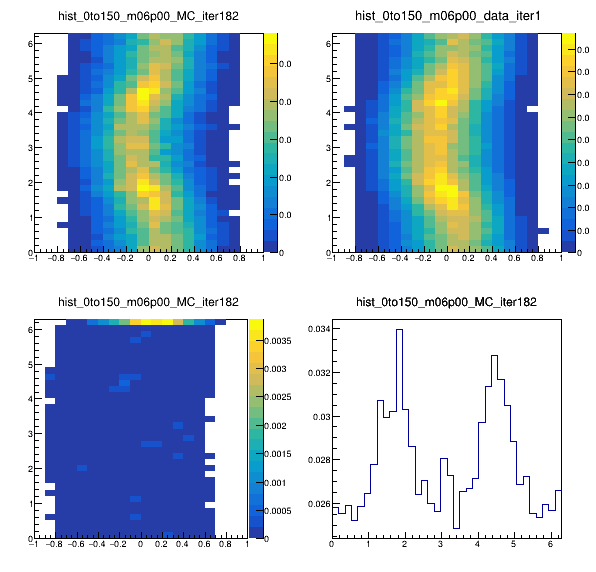

In [23]:
gStyle.SetOptStat(0)

def plotComparison(histMC, histData):
    can = TCanvas("can","can",600,600)
    can.Divide(2,2)
    can.Draw()
    can.cd(1)
    histMC.Draw("COLZ")
    can.cd(2)
    histData.Draw("COLZ")
    pad = can.cd(3)
    pad.SetRightMargin(0.155)
    pad = can.cd(3)
    hdiff = diffHist(histMC, histData)
    hdiff.Draw("COLZ")
    can.Update()
    palette = hdiff.GetListOfFunctions().FindObject("palette")
    palette.SetX1NDC(0.85)
    palette.SetX2NDC(0.9)
    can.Modified()
    can.Update()
    can.cd(4)
    nby = histMC.GetNbinsX()
    py = histMC.ProjectionY("py",1,nby)
    py.Draw("HIST")
    return can, hdiff, py

bestIndex = int(c_sorted[-1][0].item())
can1, hdiff1, py1 = plotComparison(allHistsMC[bestIndex], histsData[0][HIST_INDEX])


Warning in <TCanvas::Constructor>: Deleting canvas with same name: can


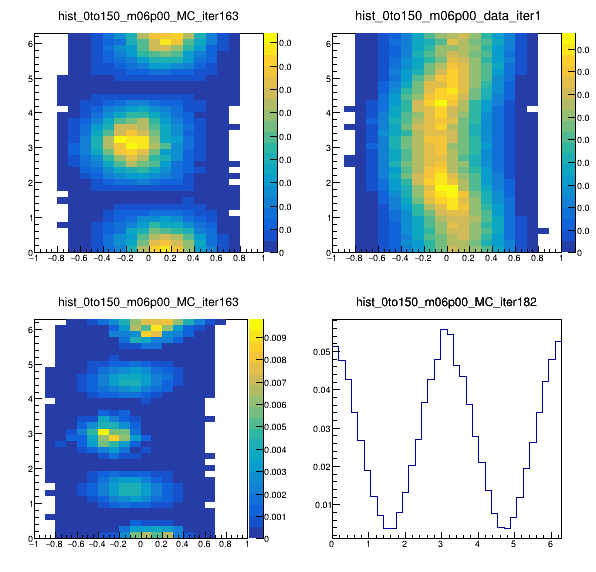

In [24]:
worstIndex = int(c_sorted[0][0].item())
can2, hdiff2, py2 = plotComparison(allHistsMC[worstIndex], histsData[0][HIST_INDEX])

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


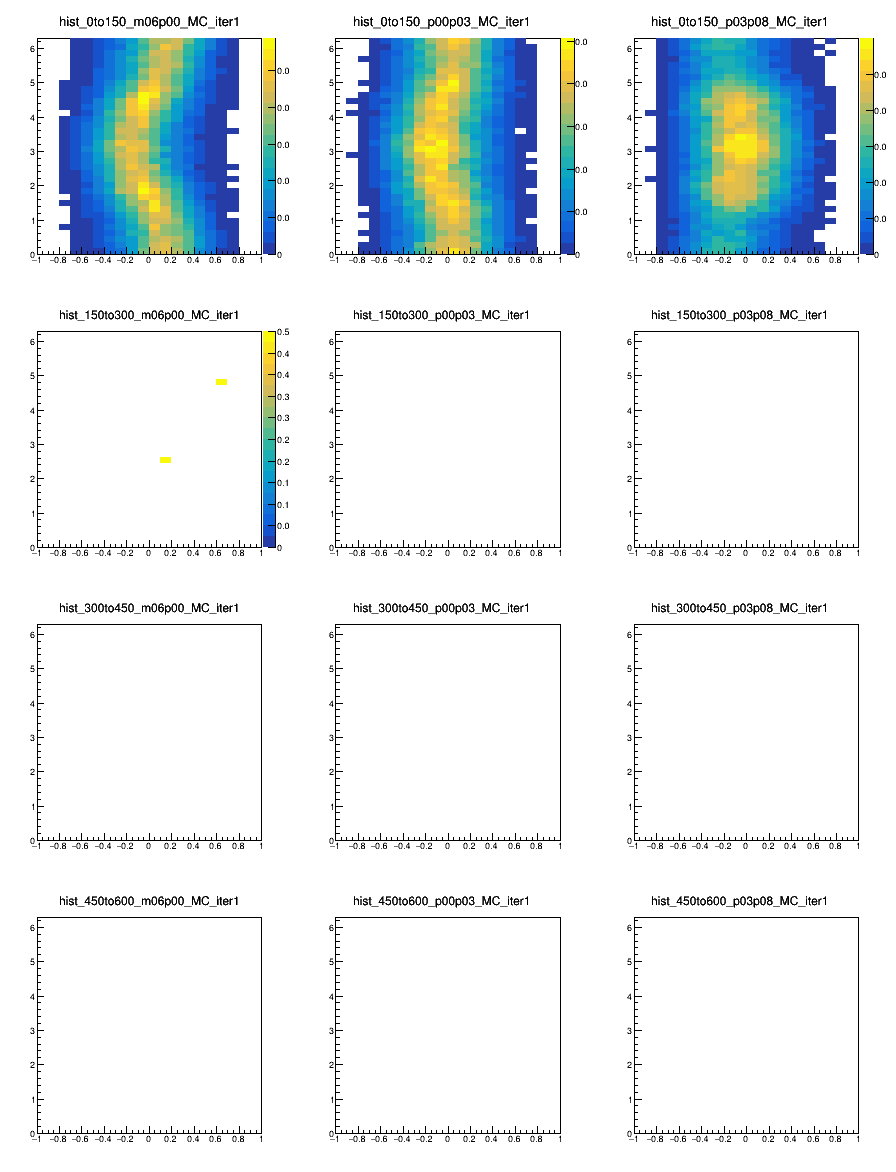

In [25]:
base_hists = histMakerMC.builder.base_hists
can3 = TCanvas("c","C",900,1200)
can3.Divide(3,4)
can3.Draw()
for i, hist in enumerate(base_hists[0]):
    can3.cd(i+1)
    if not isinstance(hist, list):
        hist.Draw("COLZ")
    else:
        print(hist)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


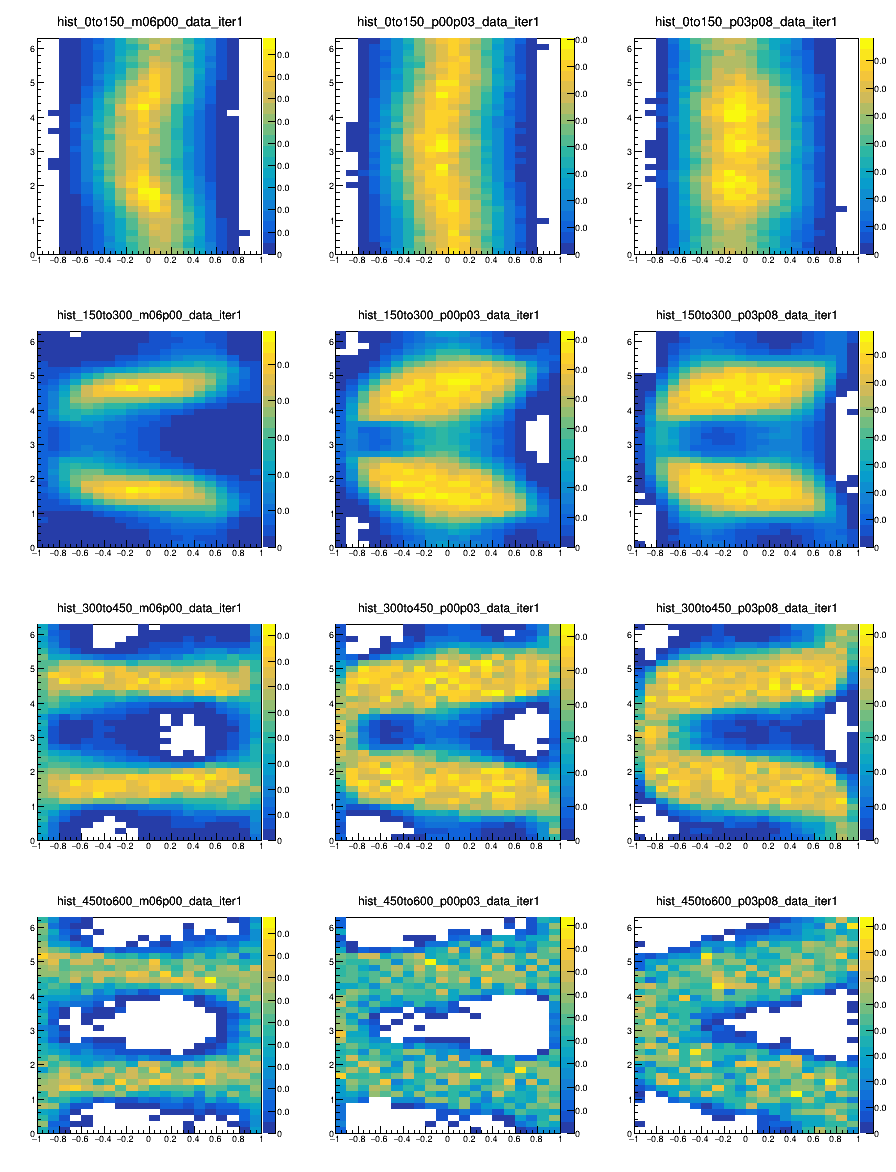

In [26]:
can4 = TCanvas("c","C",900,1200)
can4.Divide(3,4)
can4.Draw()
for i, hist in enumerate(histsData[0]):
    can4.cd(i+1)
    if not isinstance(hist, list):
        hist.Draw("COLZ")
    else:
        print(hist)

In [27]:
from ROOT import TH3F

pm = predictive_mean.reshape(101,101,101)
print(pm[100][100][100].item())
hpm = TH3F("hpm","predictive mean", 101, 0, 1, 101, 0, 2*math.pi, 101, 0, 2)
for binx in range(1,101):
    for biny in range(1,101):
        for binz in range(1,101):
            hpm.SetBinContent(binx,biny,binz,pm[binx-1][biny-1][binz-1].item())
hpm.SaveAs("pm.root")

3271.33251953125


Warning in <TROOT::Append>: Replacing existing TH1: hpm (Potential memory leak).
Info in <TH3F::SaveAs>: ROOT file pm.root has been created


In [28]:
from botorch.utils.probability.utils import ntdr as Phi
from botorch.utils.probability.utils import phi



ImportError: cannot import name 'ntdr' from 'botorch.utils.probability.utils' (/Users/harabasz/helicity/.conda/lib/python3.11/site-packages/botorch/utils/probability/utils.py)

In [ ]:
from botorch.utils.probability.utils import (
    log_ndtr as log_Phi,
    log_phi,
    log_prob_normal_in,
    ndtr as Phi,
    phi,
)

ttt = torch.tensor([-0.1])
print(Phi(ttt))